# ECM-MPT Data Analysis

 The following notebook will go through prediction analysis for the Extracellular-Matrix Multiple Particle Tracking (ECM-MPT) study of pup age in P14, P21, P28, and P35 datasets.


## Table of Contents


  [1.   Load Data](#1.---Load-Data)<br />
  [2.   Analysis](#2.---Analysis)<br />
  [3.   Modelling](#3.---Modelling)<br />
  [4.   Evaluate Results](4.---Evaluate-Results)<br />

---

## 1.   Load Data

Loading feature dataset from AWS NanceLab Bucket: p14, p21, p28, data are present on mckenna.data/08_06_19_MPT_age_dependence while p35 data is present on mckenna.data/07_16_19_MPT_ECM_breakdown. This bucket is only available through access with Nance lab.

There are 15 total videos from each age group. Names of each dataset downloaded are present on dwnld_list.txt.

In [268]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as pl
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import xgboost as xgb
from xgboost import cv

import shap

In [2]:
dwnld_list = []
source_bucket = 'dash2927.data'
source_folder = 'ECM_work'
keyword = ['40nm', 'NT_brain_2']
s3 = boto3.resource('s3')
bucket = s3.Bucket(source_bucket)

for object in bucket.objects.all():
    folder, filename = ('/'.join(object.key.split("/")
                                 [:-1]), object.key.split("/")[-1])
    # only look in remote_folder and if any keyword(s) math filename
    if folder in source_folder and any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)):
        dwnld_list.append(s3.Object(object.bucket_name, object.key))

dwnld_list = [filename.key for filename in dwnld_list if 'features' in filename.key]

In [3]:
dwnld_list

['ECM_work/features_NT_brain_2_slice_1_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_5.csv',
 'ECM_work/features_P14_40nm_s1_v1.csv',
 'ECM_work/features_P14_40nm_s1_v2.csv',
 'ECM_work/features_P14_40nm_s1_v3.csv',
 'ECM_work/features_P14_40nm_s1_v4.csv',
 'ECM_work/features_P14_40nm_s1_v5.csv',
 'ECM_work/features_P14_40nm_s2_v1.csv',
 'ECM_work/features_P14_40nm_s2_v2.csv',
 'ECM_work/features_P14_40nm_s2_v3.csv',
 'ECM_work/features_P14_40nm_s2_v4.csv',
 'ECM_work/features_P14_40nm_s2_v5.csv',
 'ECM_work/features_P14_40nm_s3_v1.csv',
 'ECM_work/features_P14_40nm_s3_v2.csv',
 'ECM_work/features_P14_40nm_s3_v3.csv',
 'ECM_work/features_P14_40nm_s3_v4.csv',
 'ECM_work/features_P14_40nm_s3_v5.csv',
 'ECM_work/features_P21_40nm_s1_v1.csv',
 'ECM_work/features_P21_40nm_s1_v2.csv',
 'ECM_work/features_P21_40nm_s1_v3.csv',
 'ECM_work/features_P21_40nm_s1_v4.csv',
 'ECM_work/features_P21_40nm_s1_v5.csv',
 'ECM_work/features_P21_40nm_s2_v1.csv',
 'ECM_work/features_P21_40nm_s2_v2.csv',
 'ECM_work/features_P21_40nm_s2_v3.csv',
 'ECM_work/features_P21_40nm_s2_v4.csv',
 'ECM_work/features_P21_40nm_s2_v5.csv',
 'ECM_work/features_P21_40nm_s3_v1.csv',
 'ECM_work/features_P21_40nm_s3_v2.csv',
 'ECM_work/features_P21_40nm_s3_v3.csv',
 'ECM_work/features_P21_40nm_s3_v4.csv',
 'ECM_work/features_P21_40nm_s3_v5.csv',
 'ECM_work/features_P28_40nm_s1_v1.csv',
 'ECM_work/features_P28_40nm_s1_v2.csv',
 'ECM_work/features_P28_40nm_s1_v3.csv',
 'ECM_work/features_P28_40nm_s1_v4.csv',
 'ECM_work/features_P28_40nm_s1_v5.csv',
 'ECM_work/features_P28_40nm_s2_v1.csv',
 'ECM_work/features_P28_40nm_s2_v2.csv',
 'ECM_work/features_P28_40nm_s2_v3.csv',
 'ECM_work/features_P28_40nm_s2_v4.csv',
 'ECM_work/features_P28_40nm_s2_v5.csv',
 'ECM_work/features_P28_40nm_s3_v1.csv',
 'ECM_work/features_P28_40nm_s3_v2.csv',
 'ECM_work/features_P28_40nm_s3_v3.csv',
 'ECM_work/features_P28_40nm_s3_v4.csv',
 'ECM_work/features_P28_40nm_s3_v5.csv']

In [5]:
cnt = 0
for dwnld_file in dwnld_list:
    folder, filename = (dwnld_file.split("/")[0], dwnld_file.split("/")[-1])
    try:
        aws.download_s3(dwnld_file, filename, bucket_name=source_bucket)
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[2128], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[2128], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[cnt], index=fstats.index)
        cnt += 1
        if cnt == 1:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    except:
            print('Skipped!: {}'.format(filename))
    os.remove(f'./{filename}')

features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P14_40nm_s1_v4.csv size: (140, 91)
featur

## 2.   Analysis

The following columns are present within the downloaded datasets:

In [6]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

Many of these features are not useful for prediction or have data which may negatively impact classification. The following features and the target feature are defined in the following cell. We also remove any datapoints that are empty or infinite:

In [7]:
fstats_tot
features = [
    'alpha', 
    'D_fit', 
    'kurtosis', 
    'asymmetry1', 
    'asymmetry2',
    'asymmetry3', 
    'AR', 
    'elongation', 
    'boundedness', 
    'fractal_dim',
    'trappedness', 
    'efficiency', 
    'straightness', 
    'MSD_ratio', 
    'frames',   
    'Deff1', 
    'Deff2',
    'angle_mean', 
    'angle_mag_mean', 
    'angle_var', 
    'dist_tot', 
    'dist_net', 
    'progression', 
    'Mean alpha',
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',  
]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [8]:
# Showing a piece of our data:
ecm.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,Video Number
0,0.0,0.445227,16.493781,5.457711,0.900742,0.161642,0.301680,2.104323,0.524788,0.040769,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
1,1.0,0.107756,0.316246,3.334612,0.071551,0.760212,0.009322,1.213024,0.175614,0.096920,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
2,2.0,0.046968,0.440548,2.587983,0.054303,0.788683,0.007003,1.087747,0.080668,0.098123,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
3,3.0,1.759901,2.452218,2.516403,0.984714,0.062057,0.494242,3.654338,0.726353,0.105210,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
4,4.0,0.438945,8.270880,2.176721,0.997136,0.026778,0.596387,5.244316,0.809317,0.227229,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0


Before prediction, it is required to balance data. As shown, The current dataset is highly imbalance with most datapoints belonging to P21 and P35 categories. The dataset is reduced using random sampling of each target category.

In [11]:
ecm_14 = ecm[ecm[target] == 14]
ecm_2128 = ecm[ecm[target] == 2128]
ecm_35 = ecm[ecm[target] == 35]
print(f"Ratio before data balance (P14:P21/28:P35) = {len(ecm_14)}:{len(ecm_2128)}:{len(ecm_35)}")
ecm_list = [ecm_14, ecm_2128, ecm_35]
for i in range(len(ecm_list)):
    ratio = 6000/len(ecm_list[i])
    ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
print(f"Ratio before after balance (P14:P21/28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}")
bal_ecm = pd.concat(ecm_list)

Ratio before data balance (P14:P21/28:P35) = 6416:26859:17169
Ratio before after balance (P14:P21/28:P35) = 6000:6000:6000


## 3.   Modelling

The model used for this study is an extreme gradient boosting (XGBoost) decision tree which is a boosted decision tree. This model was used due to its past results within competitions and research.

In [12]:
# Using checkerboard binning for data split:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [13]:
bins = list(range(0, 2048+1, 256))
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

cols = bal_ecm.columns.tolist()
cols = cols[-3:] + cols[:-3]
bal_ecm = bal_ecm[cols]

In [15]:
le = preprocessing.LabelEncoder()
X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard(8))].reset_index()
X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard(8))].reset_index()
y_train = le.fit_transform(X_train[target])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test[target])
y_val = le.fit_transform(X_val[target])
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [140]:
param = {'max_depth': 4,
         'eta': 0.2,
         'min_child_weight': 1,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 0,
         'subsample': 0.7,
         'colsample_bytree': 0.9}

In [141]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-merror:0.400983	train-merror:0.329761
[1]	eval-merror:0.377515	train-merror:0.299381
[2]	eval-merror:0.359857	train-merror:0.294079
[3]	eval-merror:0.349575	train-merror:0.294079
[4]	eval-merror:0.35114	train-merror:0.275961
[5]	eval-merror:0.35114	train-merror:0.269775
[6]	eval-merror:0.350246	train-merror:0.269885
[7]	eval-merror:0.350022	train-merror:0.26646
[8]	eval-merror:0.34734	train-merror:0.261158
[9]	eval-merror:0.348905	train-merror:0.259832
[10]	eval-merror:0.34287	train-merror:0.254971
[11]	eval-merror:0.3384	train-merror:0.247791
[12]	eval-merror:0.341976	train-merror:0.244255
[13]	eval-merror:0.340411	train-merror:0.242709
[14]	eval-merror:0.339741	train-merror:0.237075
[15]	eval-merror:0.339964	train-merror:0.233981
[16]	eval-merror:0.343093	train-merror:0.232103
[17]	eval-merror:0.338623	train-merror:0.227022
[18]	eval-merror:0.341976	train-merror:0.223707
[19]	eval-merror:0.345776	train-merror:0.21973
[20]	eval-merror:0.346223	train-merror:0.2173
[21]	eval-me

In [142]:
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.6616003576218149


In [143]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 4.   Evaluate Results

In [285]:
print('0 == {}'.format(le.inverse_transform([0])))
print('1 == {}'.format(le.inverse_transform([1])))
print('2 == {}'.format(le.inverse_transform([2])))
class_names = ['P14', 'P35', 'P21/P28']

0 == [14]
1 == [35]
2 == [2128]


In [271]:
print(classification_report(y_test, pred, digits=4, target_names = class_names))

              precision    recall  f1-score   support

         P14     0.7562    0.7790    0.7674      1489
         P35     0.6571    0.6910    0.6736      1495
     P21/P28     0.5307    0.4872    0.5080      1490

    accuracy                         0.6524      4474
   macro avg     0.6480    0.6524    0.6497      4474
weighted avg     0.6480    0.6524    0.6497      4474



In [280]:
cm = confusion_matrix(y_test, pred) # ordered in [0,1,2] (i.e. ['P14', 'P35', 'P21/P28'])
perm = [0,2,1]
idx = np.empty_like(perm)
idx[perm] = np.arange(len(perm))
cm_array = np.array([cm[:, idx][0], cm[:, idx][2], cm[:, idx][1]])  # rearranged copy in [0,2,1]
adj_names = ['P14', 'P21/P28', 'P35']

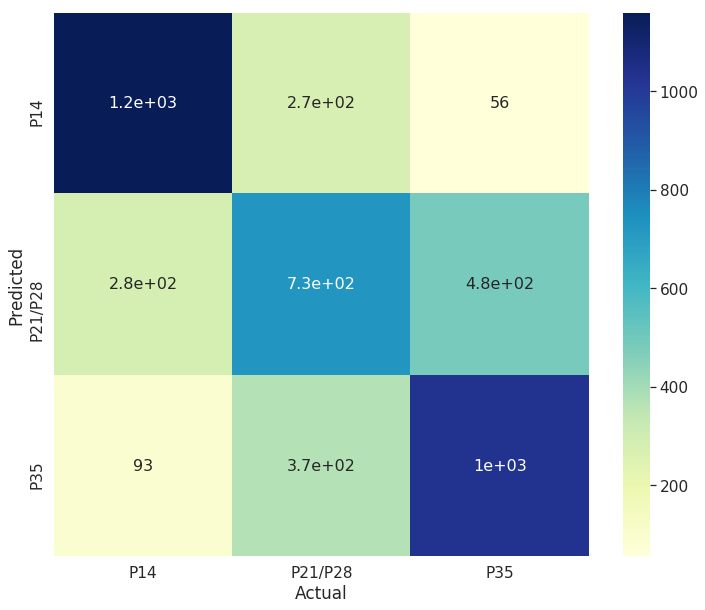

In [282]:
pl.figure(figsize=(12,10))
df_cm = pd.DataFrame(cm_array, index = adj_names, columns = adj_names)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Actual', ylabel='Predicted')

pl.show()

* Training trajectories for each age
* Weighted score at the bottom
* 

In [149]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[features])

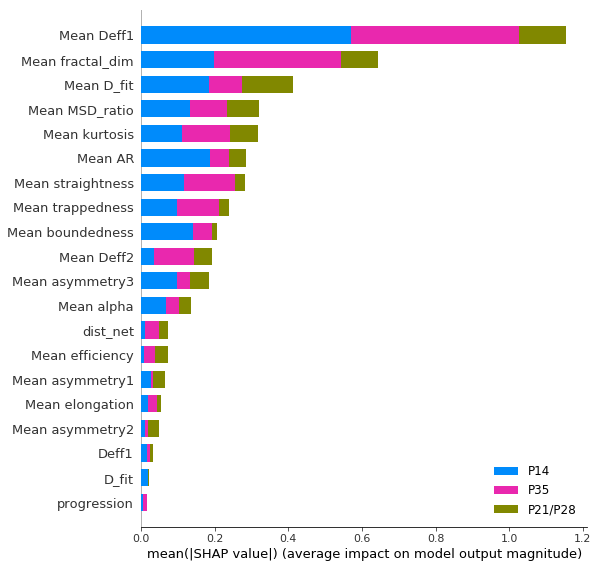

In [151]:
shap.summary_plot(shap_values, X_test[features], class_names = class_names, title = 'Total SHAP Values')

In [152]:
top_feat = ['Mean Deff1', 'Mean fractal_dim', 'Mean D_fit', 'Mean MSD_ratio', 'Mean kurtosis', 'Mean Deff2']

In [153]:
%matplotlib inline

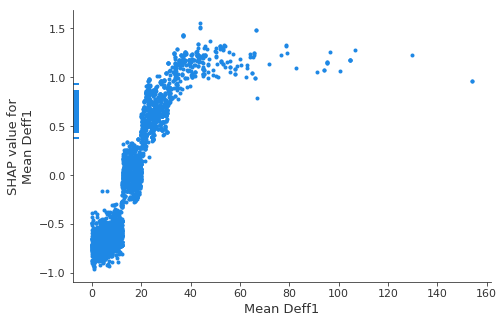

In [154]:
shap.dependence_plot("Mean Deff1", shap_values[0], X_test[features], interaction_index = None)

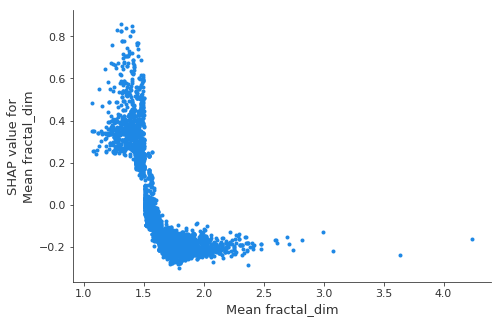

In [162]:
shap.dependence_plot("Mean fractal_dim", shap_values[0], X_test[features], interaction_index = None)

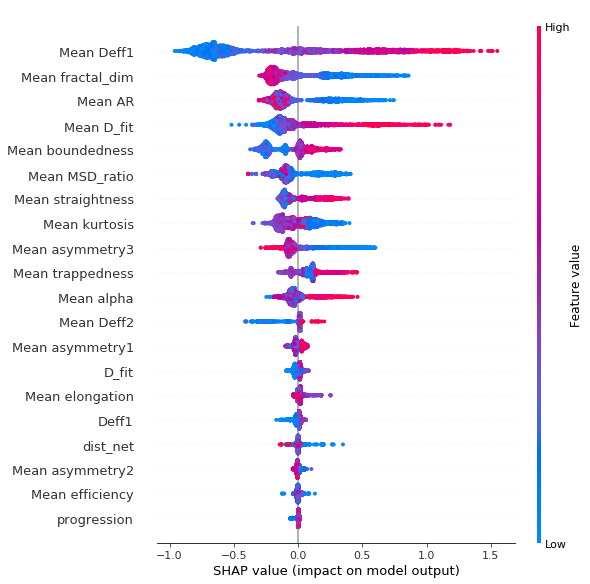

In [155]:
shap.summary_plot(shap_values[0], X_test[features], class_names = class_names, title = 'SHAP Value for P14')

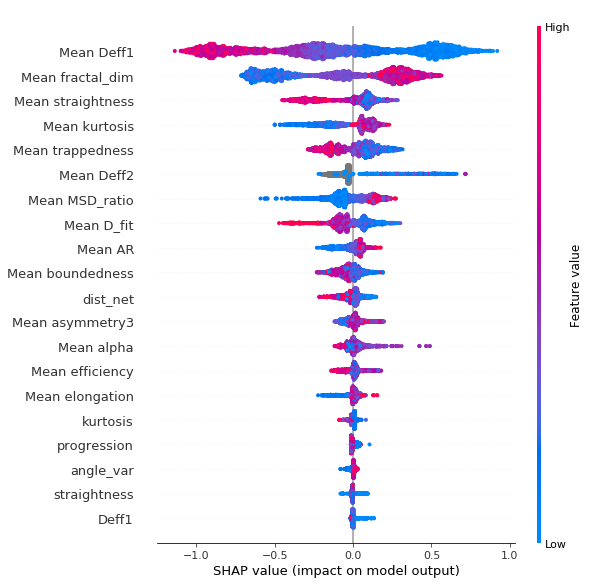

In [156]:
shap.summary_plot(shap_values[1], X_test[features], class_names = class_names, title = 'SHAP Value for P21')

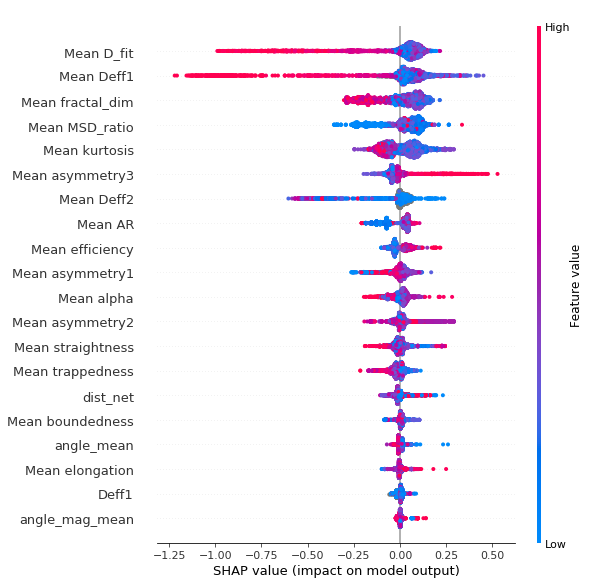

In [157]:
shap.summary_plot(shap_values[2], X_test[features], class_names = class_names, title='SHAP Value for P28')

In [267]:
from modules import anim_plot
from importlib import reload
reload(anim_plot)

_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[1], top_feat[2])
_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[2], top_feat[3])
_ = anim_plot.rotate_3d(results, top_feat[1], top_feat[2], top_feat[3])

MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.


* Try analysis without P21 data
* Try combining
* [Done] Do a video of 3d plots
* SHAP summitive
* SHAP bounds
* Keep wrking on random forest


* While waiting for review
* Pot. change algorithm to rand forest


* On exp end, Mike will get adult dataset


* Make methods: how data was split, how training eval test, SHAP, algorithm, link to github
* Wrk on discusion (why, limitations, etc)
* Results

* Nxt chkpt: January 17th 

* Histogram of precision of each analysis


In [234]:
from xgboost import XGBClassifier

In [247]:


le = preprocessing.LabelEncoder()
X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard(8))].reset_index()
X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard(8))].reset_index()
y_train = le.fit_transform(X_train[target])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test[target])
y_val = le.fit_transform(X_val[target])
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [253]:
len(features)

39

In [254]:
model.fit(X_train[features], y_train, verbose=False, eval_set=[(X_val[features],y_val)], eval_metric='mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [257]:
model.feature_importances_

array([0.00488602, 0.01077509, 0.00752481, 0.0115241 , 0.        ,
       0.        , 0.00950376, 0.        , 0.01252883, 0.00155771,
       0.        , 0.00674376, 0.00139991, 0.00292409, 0.00414561,
       0.023746  , 0.        , 0.00745469, 0.01113198, 0.0103123 ,
       0.00956745, 0.01628896, 0.01888131, 0.02640669, 0.04167866,
       0.036145  , 0.02122412, 0.02855108, 0.03759283, 0.04081781,
       0.02379152, 0.03340015, 0.09645088, 0.07280635, 0.02323653,
       0.07497469, 0.04445055, 0.18200752, 0.04556918], dtype=float32)

In [261]:
np.array(features)[np.array(model.feature_importances_ > 0)]

array(['Mean fractal_dim', 'Mean Deff1'], dtype='<U17')

In [265]:
# Feature search: 

thresh = np.arange(-.002,.1,.002)
best_acc = -1
best_thresh = -1
model = XGBClassifier()
model2 = XGBClassifier()
model.fit(X_train[features], y_train, verbose=False, eval_set=[(X_val[features],y_val)], eval_metric='mlogloss')
for t in thresh:
    print(f"Using thresh = {t} ",end = '| ')
    new_feat = np.array(features)[np.array(model.feature_importances_ > t)]
    model2.fit(X_train[new_feat], y_train, verbose=False, eval_set=[(X_val[new_feat],y_val)], eval_metric='mlogloss')
    pred3 = model2.predict(X_test[new_feat])
    acc = metrics.accuracy_score(y_test, pred3)
    print(f"Accuracy = {acc} ",end = '| ')
    if acc >= best_acc:
        best_thresh = t
        best_acc = acc
    print(f"Best accuracy = {best_acc}, Best threshold = {best_thresh}")
print(f"Features used:\n{np.array(features)[np.array(model.feature_importances_ > best_thresh)]}")


Using thresh = -0.002 | Accuracy = 0.6667411712114439 | Best accuracy = 0.6667411712114439, Best threshold = -0.002
Using thresh = 0.0 | Accuracy = 0.6667411712114439 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.002 | Accuracy = 0.6642825212337953 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.004 | Accuracy = 0.6629414394278051 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.006 | Accuracy = 0.6656236030397854 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.008 | Accuracy = 0.6624944121591417 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.01 | Accuracy = 0.6629414394278051 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.012 | Accuracy = 0.6618238712561466 | Best accuracy = 0.6667411712114439, Best threshold = 0.0
Using thresh = 0.014 | Accuracy = 0.6569065713008494 | Best accuracy = 0.6667411712114439, Best thresho

In [233]:
param = {'max_depth': 7, # 4
         'eta': 0.2, # 0.2
         'min_child_weight': 1, # 1
         'verbosity': 0, # 0
         'objective': 'multi:softprob',
         'num_class': 3, # 3
         'silent': 'True',
         'gamma': 5, # 0
         'subsample': 0.7, # 0.7
         'colsample_bytree': 0.9, # 0.9
         'eval_metric': 'mlogloss'} 

watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 20
bst = xgb.train(param, dtrain, num_round, watchlist)

####

label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
print("Accuracy:", metrics.accuracy_score(y_test, pred))

[0]	eval-mlogloss:1.02082	train-mlogloss:0.96808
[1]	eval-mlogloss:0.957149	train-mlogloss:0.872346
[2]	eval-mlogloss:0.910724	train-mlogloss:0.793713
[3]	eval-mlogloss:0.875133	train-mlogloss:0.732768
[4]	eval-mlogloss:0.846709	train-mlogloss:0.681007
[5]	eval-mlogloss:0.823326	train-mlogloss:0.640113
[6]	eval-mlogloss:0.806273	train-mlogloss:0.606266
[7]	eval-mlogloss:0.79274	train-mlogloss:0.577405
[8]	eval-mlogloss:0.781803	train-mlogloss:0.552756
[9]	eval-mlogloss:0.773692	train-mlogloss:0.533648
[10]	eval-mlogloss:0.76774	train-mlogloss:0.513265
[11]	eval-mlogloss:0.760155	train-mlogloss:0.497816
[12]	eval-mlogloss:0.756868	train-mlogloss:0.481931
[13]	eval-mlogloss:0.751627	train-mlogloss:0.471459
[14]	eval-mlogloss:0.748646	train-mlogloss:0.461815
[15]	eval-mlogloss:0.747441	train-mlogloss:0.452581
[16]	eval-mlogloss:0.745666	train-mlogloss:0.444645
[17]	eval-mlogloss:0.743773	train-mlogloss:0.439509
[18]	eval-mlogloss:0.742134	train-mlogloss:0.430944
[19]	eval-mlogloss:0.74129